In [1]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
import gensim
from itertools import product
from drazin import *

%matplotlib inline

# Make team dictionary

In [2]:
fd = pd.read_csv('FanGraphs_Fielders.csv')
bat = pd.read_csv('FanGraphs_Batting.csv')

fd = pd.merge(fd, bat, on=['Season', 'playerid', 'Name'])
teams = fd.Team_x.unique()

In [3]:
#dct = {k:fd[fd.Team_x==k]['Team_y'].values[1] for k in teams}

## Create single DataFrame

In [2]:
dct = {'- - -': '- - -',
 'ANA': 'Angels',
 'ARI': 'Diamondbacks',
 'ATL': 'Braves',
 'BAL': 'Orioles',
 'BOS': 'Red Sox',
 'CHC': 'Cubs',
 'CHW': 'White Sox',
 'CIN': 'Reds',
 'CLE': 'Indians',
 'COL': 'Rockies',
 'DET': 'Tigers',
 'FLA': 'Marlins',
 'HOU': 'Astros',
 'KCR': 'Royals',
 'LAA': 'Angels',
 'LAD': 'Dodgers',
 'MIA': 'Marlins',
 'MIL': 'Brewers',
 'MIN': 'Twins',
 'MON': 'Expos',
 'NYM': 'Mets',
 'NYY': 'Yankees',
 'OAK': 'Athletics',
 'PHI': 'Phillies',
 'PIT': 'Pirates',
 'SDP': 'Padres',
 'SEA': 'Mariners',
 'SFG': 'Giants',
 'STL': 'Cardinals',
 'TBD': 'Devil Rays',
 'TBR': 'Rays',
 'TEX': 'Rangers',
 'TOR': 'Blue Jays',
 'WSN': 'Nationals'}

In [3]:
years = list(range(2002,1+2016))

sp = pd.read_csv('FanGraphs_Starters.csv')# ,index_col=['playerid','Season'])#;print(sp.sample(3))
rp = pd.read_csv('FanGraphs_Relievers.csv')#,index_col=['playerid','Season'])
fd = pd.read_csv('FanGraphs_Fielders.csv')#,index_col=['playerid','Season'])
bat = pd.read_csv('FanGraphs_Batting.csv')#,index_col=['playerid','Season'])

fd.loc[[True]*len(fd),'Team'] = [dct[k] for k in fd.Team]#;print(fd.sample(3))

fd.insert(2,'Seasonid',[tuple(row) for row in fd[['playerid','Season']].values])

mask1 = fd.Seasonid.isin([tuple(row) for row in sp[['playerid','Season']].values])
print('fd',len(fd),'mask',len(mask1))
fd.drop(fd[mask1].index,inplace=True)

mask2 = fd.Seasonid.isin([tuple(row) for row in rp[['playerid','Season']].values])
print('fd',len(fd),'mask',len(mask2))
fd.drop(fd[mask2].index,inplace=True)

fd.drop('Seasonid',axis=1,inplace=True)
fd.loc[fd.Pos.isin(['1B','2B','3B','RF','LF','CF','SS']),'Pos'] = 'FD'
print(fd.sample(4))
sp.insert(2, 'Pos', 'P')
rp.insert(2,'Pos', 'P')
p = pd.concat([sp,rp,fd], ignore_index=True)
p.loc[p.Team=='Devil Rays','Team'] = 'Rays'
p.loc[p.Team=='Expos','Team'] = 'Nationals'
#p.drop(p[p.Team=='- - -'].index,inplace=True)
p.drop(p[p.Season<2002].index,inplace=True)
p.reset_index()
del(dct['MON'])
del(dct['TBD'])
#del(dct['- - -'])
teams = dct.values()

print('p',len(p))
player_cnts = Counter(p.playerid)
p.drop_duplicates(inplace=True)
#for pid in sp['playerid']:
#    mask = (sp['playerid']==pid)&(sp['Team']=='- - -')

fd 19193 mask 19193
fd 16667 mask 16667
       Season           Name       Team Pos  playerid
9061     2007   Darin Erstad  White Sox  FD        11
18332    2015     Joe Beimel   Mariners   P       979
1842     2007   Mike Redmond      Twins   C       538
6984     2012  Josh Harrison    Pirates  FD      8202
p 19195


In [4]:
p.insert(1, 'Change_Type', 'No Change')

In [ ]:
(one_player.Season==y)

In [ ]:
by_player = p.groupby('playerid')
for g in by_player.groups:
    one_player = by_player.get_group(g)
    #if sum(one_player['Team']=='- - -'):
    #    print(by_player.get_group(g).sort_values('Season'), end='\n\n')
    #if g in range(100,200): break
    
    for y in sorted(one_player['Season'])[1:]:
        #print(y)
        if sum(one_player.Season==y-1)==0: continue
        #print(pid, y)
        #print(p[(p.playerid==pid) * (p.Season==y)].Team.values[0])
        #print(p[(p.playerid==pid) * (p.Season==y-1)].Team.values[0])
        #print(one_player[one_player.Season==y].index)
        if one_player[(one_player.Season==y)].Team.values[0] != one_player[(one_player.Season==y-1)].Team.values[0]:
            if one_player[(one_player.Season==y-1)]['Change_Type'].values[0] == 'Arrive':
                p.loc[one_player[one_player.Season==y-1].index,'Change_Type'] = 'Arrive Leave'
                p.loc[one_player[one_player.Season==y].index,'Change_Type'] = 'Arrive'

            else:
                p.loc[one_player[one_player.Season==y-1].index,'Change_Type'] = 'Leave'
                p.loc[one_player[one_player.Season==y].index,'Change_Type'] = 'Arrive'

In [5]:
p.sort_values(by=['playerid', 'Season'], inplace =True)
prev_team = ''
prev_pid = -1
prev_chg = ''
prev_ixd = 1
for idx, (name, chg, pos, season, team, pid) in zip(p.index,p.values):
    if pid == prev_pid:
        if team == '- - -':
            p.loc[idx, 'Team'] == prev_team
            team = prev_team
        if team != prev_team:
            if prev_chg == 'No Change':
                p.loc[prev_idx, 'Change_Type'] = 'Leave'
            else:
                p.loc[prev_idx, 'Change_Type'] = 'Arrive Leave'
            p.loc[idx, 'Change_Type'] = 'Arrive'
            prev_chg = 'Arrive'
        else:
            prev_chg = 'No Change'
    else:
        p.loc[idx, 'Change_Type'] = 'Arrive'
        prev_chg = 'Arrive'
    prev_team = team
    prev_pid = pid
    prev_idx = idx

In [6]:
p

,Name,Change_Type,Pos,Season,Team,playerid
12749,Alfredo Amezaga,Arrive,FD,2002,Angels,1
11355,Alfredo Amezaga,No Change,FD,2003,Angels,1
7809,Alfredo Amezaga,Leave,FD,2004,Angels,1
6220,Alfredo Amezaga,Arrive,FD,2006,Marlins,1
5311,Alfredo Amezaga,No Change,FD,2007,Marlins,1
6957,Alfredo Amezaga,No Change,FD,2008,Marlins,1
8591,Alfredo Amezaga,Leave,FD,2009,Marlins,1
11471,Alfredo Amezaga,Arrive,FD,2011,- - -,1
13197,Garret Anderson,Arrive,FD,2002,Angels,2
6676,Garret Anderson,No Change,FD,2003,Angels,2


In [ ]:
p[p.Change_Type!='Arrive Leave'].sort_values(by=['playerid', 'Season'])

In [7]:
p.to_csv('combined_cleaned.csv')

## Analyze/Visualize Data

In [5]:
print('P count:',sum(p.Pos=='P'))
p[p.Name=='Doug Waechter']

P count: 5686


,Name,Pos,Season,Team,playerid
2988,Doug Waechter,P,2005,Rays,1814
3369,Doug Waechter,P,2004,Rays,1814
4650,Doug Waechter,P,2008,Marlins,1814
18358,Doug Waechter,P,2003,Rays,1814
18739,Doug Waechter,P,2006,Rays,1814


In [6]:
print('Year|Player Count')
for i in years:
    print(i,len(p[p.Season==i]['playerid'].unique()))

Year|Player Count
2002 878
2003 867
2004 895
2005 872
2006 850
2007 906
2008 912
2009 874
2010 899
2011 905
2012 911
2013 928
2014 918
2015 920
2016 915


In [7]:
teams = p.groupby(['Team','Season'])

In [8]:
print('  Year-->\t 02  03  04  05  06  07  08  09  10  11  12  13  14  15  16')
for t in dct.values():
    print('{:13}\t'.format(t),end='')
    for y in years:
        #print((t,y))
        try:
            print('{:3}'.format(len(teams.get_group((t,y)))),end=' ')
        except:
            print(' **',end=' ')
    print()

  Year-->	 02  03  04  05  06  07  08  09  10  11  12  13  14  15  16
Mets         	 38  44  44  40  36  40  41  48  46  44  45  47  44  42  51 
Nationals    	 28  39  45  42  39  44  49  41  41  40  45  36  42  39  38 
Cubs         	 39  32  32  31  35  41  35  40  35  45  36  36  46  46  40 
Marlins      	 31  33  32  34  36  36  40  39  36  37  40  48  38  41  41 
Yankees      	 35  27  31  35  36  32  41  35  35  37  38  43  40  39  36 
Giants       	 36  35  37  33  34  43  48  42  37  48  37  46  41  42  39 
White Sox    	 37  27  36  33  31  42  33  31  35  31  29  35  36  39  32 
Pirates      	 39  40  37  43  32  39  36  37  39  39  38  43  39  38  39 
Phillies     	 35  36  37  29  31  32  31  34  37  37  42  40  36  41  41 
Reds         	 35  47  43  41  33  37  45  40  37  38  38  32  42  44  45 
Royals       	 42  43  48  47  39  45  41  40  35  34  38  31  32  31  38 
Brewers      	 35  33  35  33  34  35  30  33  32  33  35  40  38  35  42 
Mariners     	 35  33  39  38 

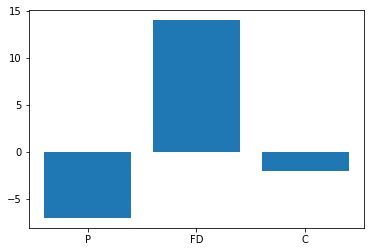

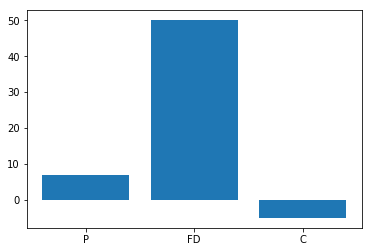

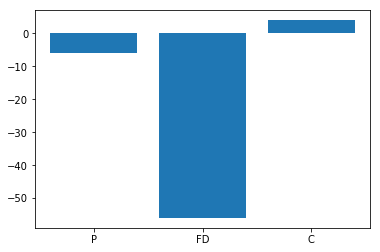

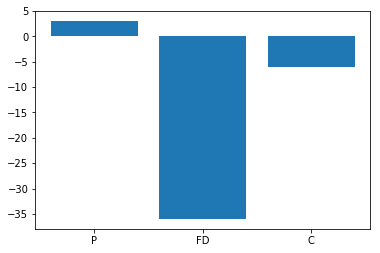

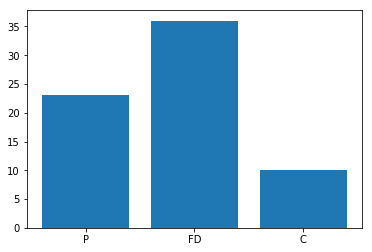

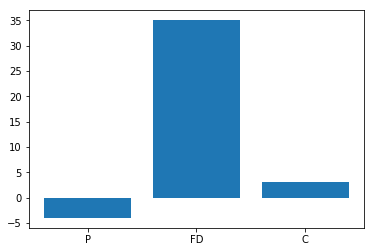

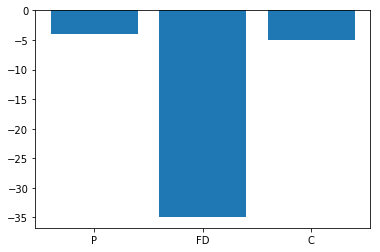

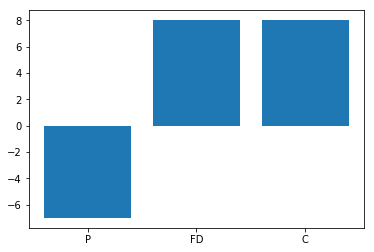

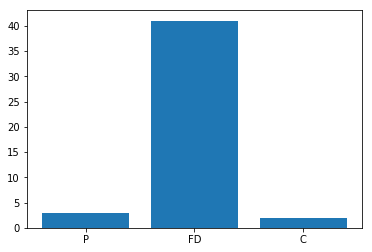

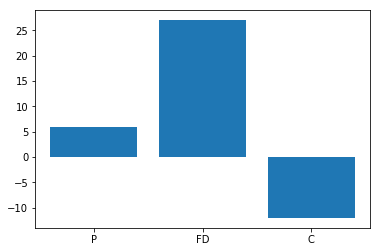

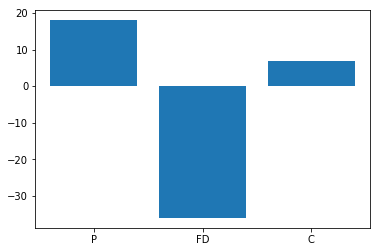

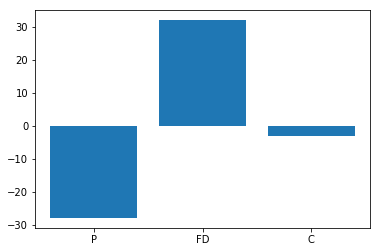

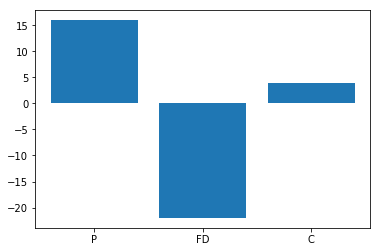

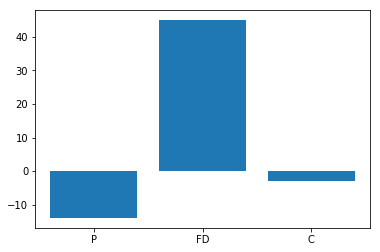

In [9]:
by_year = p.groupby(['Season'])
#print(by_year.groups)
prev = Counter(by_year.get_group(years[0]).Pos)
for i in years[1:]:
    c = Counter(by_year.get_group(i).Pos)
    dif = c.copy()
    dif.subtract(prev)
    prev = c
    plt.bar(range(len(dif.values())),dif.values())
    plt.xticks(range(len(dif)),dif)
    plt.show()

In [10]:
pd.options.display.max_rows = 200
print(p.pivot_table(values='playerid', index=['Season','Team'],columns='Pos', aggfunc='count', fill_value='-'))

Pos                  C  FD   P
Season Team                   
2002   Angels        2  23  13
       Astros        2  20  13
       Athletics     2  21  12
       Blue Jays     4  22  14
       Braves        3  21  13
       Brewers       2  21  12
       Cardinals     3  23  14
       Cubs          3  24  12
       Diamondbacks  3  22  11
       Dodgers       2  19  10
       Giants        2  23  11
       Indians       4  27  12
       Mariners      2  22  11
       Marlins       3  15  13
       Mets          3  25  10
       Nationals     2  15  11
       Orioles       2  28  14
       Padres        4  25  13
       Phillies      3  19  13
       Pirates       3  23  13
       Rangers       4  26  14
       Rays          3  30  13
       Red Sox       2  19  12
       Reds          3  20  12
       Rockies       3  16  11
       Royals        3  26  13
       Tigers        4  24  14
       Twins         2  23  14
       White Sox     3  22  12
       Yankees       3  21  11
2003   A

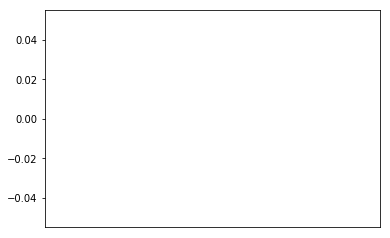

In [11]:
c = Counter(p[p.Team=='- - -'].Pos)
plt.bar(range(len(c.values())),[v/sum(p.Pos==k) for k,v in c.items()])
plt.xticks(range(len(c)),c)
plt.show()

## NLP Approach to Roles

In [12]:
teams = list(dct.values())
by_season_team = p.groupby(['Season','Team'])
def sentence_gen(season, team, num=50):
    return [' '.join(map(str,np.random.permutation(by_season_team.get_group((season,team))['playerid']))) \
            for _ in range(num)]
    

In [13]:
len(teams)*len(years)

480

In [14]:
texts = []
for y,t in product(years,teams):
    texts.extend(sentence_gen(y,t,num=300))

In [15]:
#dictionary = gensim.corpora.Dictionary(texts)

In [16]:
p[p.Pos=='C'].sample(3)

,Name,Pos,Season,Team,playerid
6428,Nick Hundley,C,2008,Padres,3376
5731,Ryan Hanigan,C,2009,Reds,4952
13931,A.J. Hinch,C,2003,Tigers,606


In [17]:
model = gensim.models.word2vec.Word2Vec(texts)

In [69]:
model.train(texts, total_examples=model.corpus_count, epochs=model.iter)

16600554

In [18]:
model.wv.n_similarity('514','4293')

0.85707206021663196

In [19]:
model.wv.n_similarity('2041','4293')

0.96702442729997218

In [20]:
model.wv.n_similarity('454','889')

0.78421060758971239

In [22]:
p[p.Pos=='FD'].sample(3)

,Name,Pos,Season,Team,playerid
15476,Luis Gonzalez,FD,2008,Marlins,55
17833,Adam LaRoche,FD,2008,Pirates,1904
8578,Andy Green,FD,2004,Diamondbacks,2991


509


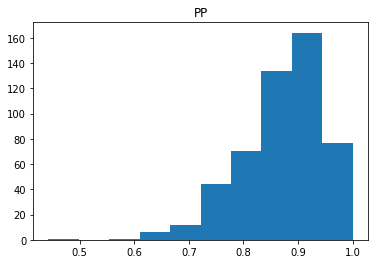

952


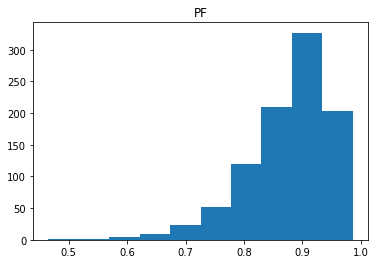

266


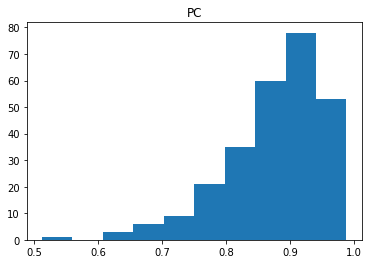

73


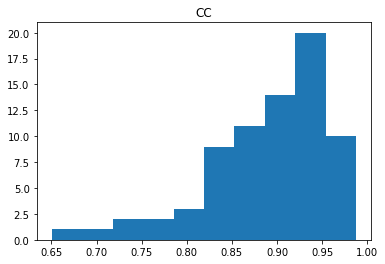

581


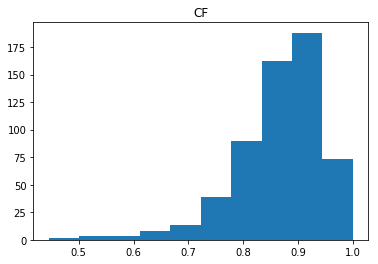

1126


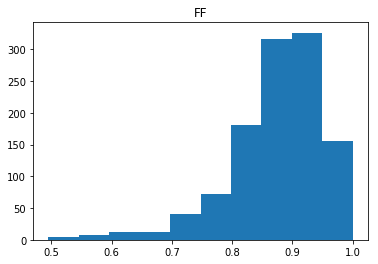

In [34]:
comp = []
for _ in range(5000):
    players = p.sample(2)
    id1,id2 = players.playerid.values
    if players.Pos.values[0] == 'P' and players.Pos.values[1] == 'P':
        comp.append((players.Pos.values,model.wv.n_similarity(str(id1),str(id2))))
for x,y in sorted(comp,key=lambda x: x[1]):
    pass
    #print('{}\t{:.4f}'.format(x,y))
print(len(comp))
plt.hist([y for x,y in comp]);plt.title('PP');plt.show()

comp = []
for _ in range(5000):
    players = p.sample(2)
    id1,id2 = players.playerid.values
    if players.Pos.values[0] == 'P' and players.Pos.values[1] == 'FD':
        comp.append((players.Pos.values,model.wv.n_similarity(str(id1),str(id2))))
print(len(comp))
plt.hist([y for x,y in comp]);plt.title('PF');plt.show()

comp = []
for _ in range(12000):
    players = p.sample(2)
    id1,id2 = players.playerid.values
    if players.Pos.values[0] == 'P' and players.Pos.values[1] == 'C':
        comp.append((players.Pos.values,model.wv.n_similarity(str(id1),str(id2))))
print(len(comp))
plt.hist([y for x,y in comp]);plt.title('PC');plt.show()

comp = []
for _ in range(16000):
    players = p.sample(2)
    id1,id2 = players.playerid.values
    if players.Pos.values[0] == 'C' and players.Pos.values[1] == 'C':
        comp.append((players.Pos.values,model.wv.n_similarity(str(id1),str(id2))))
print(len(comp))
plt.hist([y for x,y in comp]);plt.title('CC');plt.show()

comp = []
for _ in range(12000):
    players = p.sample(2)
    id1,id2 = players.playerid.values
    if players.Pos.values[0] == 'C' and players.Pos.values[1] == 'FD':
        comp.append((players.Pos.values,model.wv.n_similarity(str(id1),str(id2))))
print(len(comp))
plt.hist([y for x,y in comp]);plt.title('CF');plt.show()

comp = []
for _ in range(3000):
    players = p.sample(2)
    id1,id2 = players.playerid.values
    if players.Pos.values[0] == 'FD' and players.Pos.values[1] == 'FD':
        comp.append((players.Pos.values,model.wv.n_similarity(str(id1),str(id2))))
print(len(comp))
plt.hist([y for x,y in comp]);plt.title('FF');plt.show()

In [137]:
years = sorted(p.Season.unique())
ind_yr = {y:i for i,y in enumerate(years)}
num_indiv = 30
player_gen = np.zeros((num_indiv,len(years)))

pids = np.random.permutation(p.playerid.values)[:num_indiv]
print(pids)
p[p['playerid'].isin(pids)]

[4817 5209 1791 4538 8700 2790 8259  312 8678 4972 3254 4747  571 7466 6550
 4529  746  653  766 2027  521 6230 6983 9218 1091 6249 1717  633  513  535]


,Name,Pos,Season,Team,playerid
48,Justin Verlander,SP,2009,Tigers,8700
76,Justin Verlander,SP,2012,Tigers,8700
81,Justin Verlander,SP,2010,Tigers,8700
88,Justin Verlander,SP,2011,Tigers,8700
89,Cole Hamels,SP,2011,Phillies,4972
93,Roy Oswalt,SP,2002,Astros,571
111,Cole Hamels,SP,2014,Phillies,4972
137,Roy Oswalt,SP,2005,Astros,571
145,Roy Oswalt,SP,2004,Astros,571
150,Jeff Samardzija,SP,2014,- - -,3254


In [138]:
pos = []
for i,pid in enumerate(pids):
    player_hist = p[p['playerid']==pid]
    pos.append(player_hist['Pos'].values[0])
    #print(player_hist)
    for j,year in enumerate(range(start_y,1+end_y)):
        if year in player_hist['Season'].values:
            player_gen[i,j] = ind_t[ player_hist[player_hist['Season']==year]['Team'].values[0] ]
                
s = '''for i,pid in enumerate(pids):
    if pid in sp['playerid'].values:
        player_hist = sp[sp['playerid']==pid]
        print(player_hist)
        for j,year in enumerate(range(start_y,1+end_y)):
            if year in player_hist['Season'].values:
                player_gen[i,j] = ind_t[ player_hist[player_hist['Season']==year]['Team'].values[0] ]

    elif pid in rp['playerid'].values:
        player_hist = rp[rp['playerid']==pid]
        print(player_hist)
        for j,year in enumerate(range(start_y,1+end_y)):
            if year in player_hist['Season'].values:
                player_gen[i,j] = ind_t[ player_hist[player_hist['Season']==year]['Team'].values[0] ]
    
    elif pid in fd['playerid'].values:
        player_hist = fd[fd['playerid']==pid]
        print(player_hist)
        for j,year in enumerate(range(start_y,1+end_y)):
            if year in player_hist['Season'].values:
                player_gen[i,j] = ind_t[ player_hist[player_hist['Season']==year]['Team'].values[0] ]'''
    

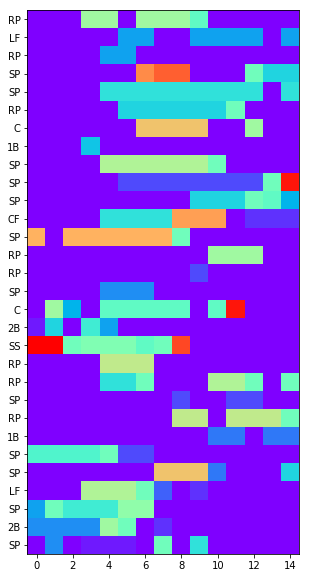

In [140]:
plt.figure(figsize=(10,10))
plt.imshow(player_gen, cmap='rainbow')
plt.yticks(range(num_indiv), pos)
plt.show()

## Finding Change Data

In [5]:
p.insert(1, 'Change_Type', 'No Change')
for y in years[1:]:
    for pid in p[p.Season==y].playerid:
        if sum((p.playerid==pid) & (p.Season==y-1))==0: continue
        #print(pid, y)
        #print(p[(p.playerid==pid) * (p.Season==y)].Team.values[0])
        #print(p[(p.playerid==pid) * (p.Season==y-1)].Team.values[0])
        if p[(p.playerid==pid) & (p.Season==y)].Team.values[0] != p[(p.playerid==pid) * (p.Season==y-1)].Team.values[0]:
            if p[(p.playerid==pid) & (p.Season==y-1)]['Change_Type'].values[0] == 'Arrive':
                p.loc[(p.playerid==pid) & (p.Season==y-1),'Change_Type'] = 'Arrive Leave'
                p.loc[(p.playerid==pid) & (p.Season==y),'Change_Type'] = 'Arrive'

            else:
                p.loc[(p.playerid==pid) & (p.Season==y-1),'Change_Type'] = 'Leave'
                p.loc[(p.playerid==pid) & (p.Season==y),'Change_Type'] = 'Arrive'
p.sample(20)

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


,Name,Change_Type,Pos,Season,Team,playerid
18245,Nelson Cruz,Arrive,P,2003,Rockies,554
8784,Eli Marrero,No Change,C,2002,Cardinals,1166
4013,Craig Stammen,No Change,P,2012,Nationals,7274
3182,Aaron Sele,No Change,P,2003,Angels,34
15640,Randy Winn,No Change,FD,2007,Giants,1235
10308,Emilio Bonifacio,No Change,FD,2010,Marlins,4054
442,John Patterson,No Change,P,2005,Nationals,71
11770,Matt Carson,No Change,FD,2009,Athletics,4748
18744,Shawn Hill,No Change,P,2006,Nationals,1882
11896,Mark DeRosa,Arrive,FD,2013,Blue Jays,1392


In [6]:
p.to_csv('combined_players_changes.csv')

In [60]:
a = np.arange(30).reshape((5,6))
a = np.random.random((5,6))
u,s,v = np.linalg.svd(a)

In [44]:
u

array([[-0.07000651, -0.77142666, -0.24112143, -0.46822528, -0.3501793 ],
       [-0.22849801, -0.49778375,  0.45623969,  0.69414729, -0.10002441],
       [-0.38698952, -0.22414084,  0.17539854, -0.28382575,  0.82986643],
       [-0.54548102,  0.04950208, -0.75503044,  0.35811076,  0.04105756],
       [-0.70397253,  0.32314499,  0.36451364, -0.30020702, -0.42072028]])

In [45]:
s

array([  9.23734286e+01,   4.70634585e+00,   5.49573583e-15,
         1.53358432e-15,   2.64768075e-16])

In [46]:
v

array([[-0.35431034, -0.37525736, -0.39620437, -0.41715139, -0.4380984 ,
        -0.45904542],
       [ 0.6310893 ,  0.39296311,  0.15483693, -0.08328925, -0.32141544,
        -0.55954162],
       [ 0.47692476, -0.64120533, -0.29779665,  0.50906148,  0.05546449,
        -0.10244875],
       [ 0.09151009, -0.23830399,  0.19904082, -0.42783131,  0.75420566,
        -0.37862127],
       [-0.48954483,  0.08294651,  0.27596747,  0.60479839,  0.07843896,
        -0.55260649],
       [-0.0265519 ,  0.47952968, -0.78395758,  0.1052773 ,  0.35595892,
        -0.13025642]])

In [47]:
u.shape

(5, 5)

In [55]:
rank = 5
s[s<0.00001] = 0

In [56]:
v.shape

(6, 6)

In [57]:
np.rank(a)

2

In [61]:
idx = np.diag_indices(min(a.shape))
sigma = np.zeros_like(a)
sigma[idx] = s

In [63]:
np.allclose(u.dot(sigma.dot(v)) - a,0)

True

In [ ]:
u